In [208]:
#import thinkplot
#import thinkstats2
import pandas as pd
import numpy as np
import math
import scipy.stats as ss
import thinkplot
import thinkstats2
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression

##Seaborn for fancy plots. 
import matplotlib.pyplot as plt
import seaborn as sns
plt.rcParams["figure.figsize"] = (15,5)

# Quiz 2 - Get Hyp'

<ul>
<li> Use this as a starting point for your work, but answer the questions on Moodle. 
<li> Publish this to your GitHub and submit the link in the question on Moodle. 
</ul>

## Potentially Useful Information

#### Data Dictionary
<ul>
<li>credit.policy: 1 if the customer meets the credit underwriting criteria of LendingClub.com, and 0 otherwise.
<li>purpose: The purpose of the loan (takes values "credit_card", "debt_consolidation", "educational", "major_purchase", "small_business", and "all_other").
<li>int.rate: The interest rate of the loan, as a proportion (a rate of 11% would be stored as 0.11). Borrowers judged by LendingClub.com to be more risky are assigned higher interest rates.
<li>installment: The monthly installments owed by the borrower if the loan is funded.
<li>log.annual.inc: The natural log of the self-reported annual income of the borrower.
<li>dti: The debt-to-income ratio of the borrower (amount of debt divided by annual income).
<li>fico: The FICO credit score of the borrower.
<li>days.with.cr.line: The number of days the borrower has had a credit line.
<li>revol.bal: The borrower's revolving balance (amount unpaid at the end of the credit card billing cycle).
<li>revol.util: The borrower's revolving line utilization rate (the amount of the credit line used relative to total credit available).
<li>inq.last.6mths: The borrower's number of inquiries by creditors in the last 6 months.
<li>not.fully.paid: 1 if the borrower failed to repay their loan, 0 if they have not failed
</ul>

#### FICO Score Groups

![FICO](fico_range.png "FICO Ranges")

#### Note on ANOVA - Might be Useful, Might Not

> @JeremyMiles is right. First, there's a rule of thumb that the ANOVA is robust to heterogeneity of variance so long as the largest variance is not more than 4 times the smallest variance. Furthermore, the general effect of heterogeneity of variance is to make the ANOVA less efficient. That is, you would have lower power. Since you have a significant effect anyway, there is less reason to be concerned here. 
- https://stats.stackexchange.com/questions/56971/alternative-to-one-way-anova-unequal-variance

In [209]:
# Please don't alter this part. 
df = pd.read_csv("loan_data.csv")
df.drop(columns={"delinq.2yrs", "pub.rec"}, inplace=True)
df.head()
df.dropna()

,credit.policy,purpose,int.rate,installment,log.annual.inc,dti,fico,days.with.cr.line,revol.bal,revol.util,inq.last.6mths,not.fully.paid
0,1,debt_consolidation,0.1189,829.10,11.350407,19.48,737,5639.958333,28854,52.1,0,0
1,1,credit_card,0.1071,228.22,11.082143,14.29,707,2760.000000,33623,76.7,0,0
2,1,debt_consolidation,0.1357,366.86,10.373491,11.63,682,4710.000000,3511,25.6,1,0
3,1,debt_consolidation,0.1008,162.34,11.350407,8.10,712,2699.958333,33667,73.2,1,0
4,1,credit_card,0.1426,102.92,11.299732,14.97,667,4066.000000,4740,39.5,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...
9573,0,all_other,0.1461,344.76,12.180755,10.39,672,10474.000000,215372,82.1,2,1
9574,0,all_other,0.1253,257.70,11.141862,0.21,722,4380.000000,184,1.1,5,1
9575,0,debt_consolidation,0.1071,97.81,10.596635,13.09,687,3450.041667,10036,82.9,8,1
9576,0,home_improvement,0.1600,351.58,10.819778,19.18,692,1800.000000,0,3.2,5,1


### Visualize/Explore Data - If You Want, You Do You

In [210]:
#Create credit-score bucket.
df["grade"] = " "
scoreCol = df.columns.get_loc("fico")
gradeCol = df.columns.get_loc("grade")

for i in range(len(df)) :
    if df.iloc[i,scoreCol] < 580:
        #print("Less than 580-"+str(df.iloc[i,scoreCol]))
        df.iloc[i,gradeCol] = "poor"
    elif df.iloc[i,scoreCol] < 670:
        #print("580-670-"+str(df.iloc[i,scoreCol]))
        df.iloc[i,gradeCol] = "fair"
    elif df.iloc[i,scoreCol] < 740:
        #print("670-740-"+str(df.iloc[i,scoreCol]))
        df.iloc[i,gradeCol] = "good"
    elif df.iloc[i,scoreCol] < 800:
        #print("740-800-"+str(df.iloc[i,scoreCol]))
        df.iloc[i,gradeCol] = "very good"
    else:
        #print("800+-"+str(df.iloc[i,scoreCol]))
        df.iloc[i,gradeCol] = "excellent"
#print(str(scoreCol)+ " "+ str(gradeCol))
df.head(25)

,credit.policy,purpose,int.rate,installment,log.annual.inc,dti,fico,days.with.cr.line,revol.bal,revol.util,inq.last.6mths,not.fully.paid,grade
0,1,debt_consolidation,0.1189,829.10,11.350407,19.48,737,5639.958333,28854,52.1,0,0,good
1,1,credit_card,0.1071,228.22,11.082143,14.29,707,2760.000000,33623,76.7,0,0,good
2,1,debt_consolidation,0.1357,366.86,10.373491,11.63,682,4710.000000,3511,25.6,1,0,good
3,1,debt_consolidation,0.1008,162.34,11.350407,8.10,712,2699.958333,33667,73.2,1,0,good
4,1,credit_card,0.1426,102.92,11.299732,14.97,667,4066.000000,4740,39.5,0,0,fair
5,1,credit_card,0.0788,125.13,11.904968,16.98,727,6120.041667,50807,51.0,0,0,good
6,1,debt_consolidation,0.1496,194.02,10.714418,4.00,667,3180.041667,3839,76.8,0,1,fair
7,1,all_other,0.1114,131.22,11.002100,11.08,722,5116.000000,24220,68.6,0,1,good
8,1,home_improvement,0.1134,87.19,11.407565,17.25,682,3989.000000,69909,51.1,1,0,good
9,1,debt_consolidation,0.1221,84.12,10.203592,10.00,707,2730.041667,5630,23.0,1,0,good


In [211]:
#In generic cases, we can automate this:
bins = np.arange(580, 860, 60) #or
bins = np.array([580, 670, 740, 800])
indicies = np.digitize(df["fico"], bins)
groups = df.groupby(indicies)
for i, group in groups:
    print(i, group["fico"].min(), len(group), np.exp(group["log.annual.inc"]).mean())

1 612 1341 60231.432107263354
2 672 6007 67593.95498610557
3 742 2085 74025.49061873481
4 802 145 96581.13203052751


## Solutions

In [212]:
#Paid fully
dfp=df[df["not.fully.paid"]==1]
dfp.head()

,credit.policy,purpose,int.rate,installment,log.annual.inc,dti,fico,days.with.cr.line,revol.bal,revol.util,inq.last.6mths,not.fully.paid,grade
6,1,debt_consolidation,0.1496,194.02,10.714418,4.00,667,3180.041667,3839,76.8,0,1,fair
7,1,all_other,0.1114,131.22,11.002100,11.08,722,5116.000000,24220,68.6,0,1,good
57,1,credit_card,0.1343,678.08,11.884489,10.15,682,4209.958333,41674,74.1,0,1,good
65,1,all_other,0.1059,32.55,10.433822,14.47,687,1110.000000,4485,36.9,1,1,good
73,1,small_business,0.1501,225.37,12.269047,6.45,677,6240.000000,56411,75.3,0,1,good


In [213]:
#not paid Fully
dfn=df[df["not.fully.paid"]==0]
dfn.head(10)

,credit.policy,purpose,int.rate,installment,log.annual.inc,dti,fico,days.with.cr.line,revol.bal,revol.util,inq.last.6mths,not.fully.paid,grade
0,1,debt_consolidation,0.1189,829.10,11.350407,19.48,737,5639.958333,28854,52.1,0,0,good
1,1,credit_card,0.1071,228.22,11.082143,14.29,707,2760.000000,33623,76.7,0,0,good
2,1,debt_consolidation,0.1357,366.86,10.373491,11.63,682,4710.000000,3511,25.6,1,0,good
3,1,debt_consolidation,0.1008,162.34,11.350407,8.10,712,2699.958333,33667,73.2,1,0,good
4,1,credit_card,0.1426,102.92,11.299732,14.97,667,4066.000000,4740,39.5,0,0,fair
5,1,credit_card,0.0788,125.13,11.904968,16.98,727,6120.041667,50807,51.0,0,0,good
8,1,home_improvement,0.1134,87.19,11.407565,17.25,682,3989.000000,69909,51.1,1,0,good
9,1,debt_consolidation,0.1221,84.12,10.203592,10.00,707,2730.041667,5630,23.0,1,0,good
10,1,debt_consolidation,0.1347,360.43,10.434116,22.09,677,6713.041667,13846,71.0,2,0,good
11,1,debt_consolidation,0.1324,253.58,11.835009,9.16,662,4298.000000,5122,18.2,2,0,fair


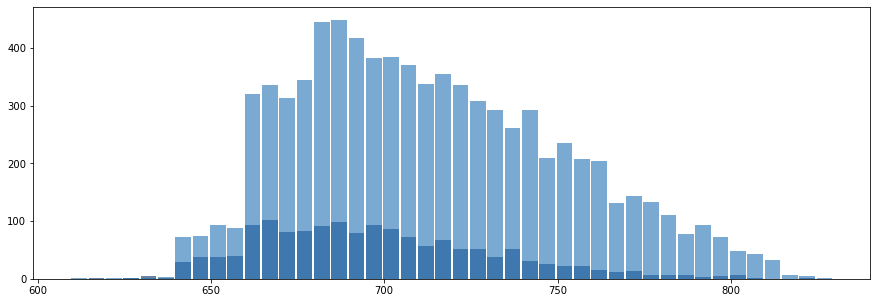

In [214]:
hist1 = thinkstats2.Hist(dfp["fico"])
hist2= thinkstats2.Hist(dfn["fico"])
thinkplot.Hist(hist1)
thinkplot.Hist(hist2)

In [215]:
df.head(2)

,credit.policy,purpose,int.rate,installment,log.annual.inc,dti,fico,days.with.cr.line,revol.bal,revol.util,inq.last.6mths,not.fully.paid,grade
0,1,debt_consolidation,0.1189,829.10,11.350407,19.48,737,5639.958333,28854,52.1,0,0,good
1,1,credit_card,0.1071,228.22,11.082143,14.29,707,2760.000000,33623,76.7,0,0,good


In [216]:
dfc=df[df["credit.policy"]==1]
dfnc=df[df["credit.policy"]==0]

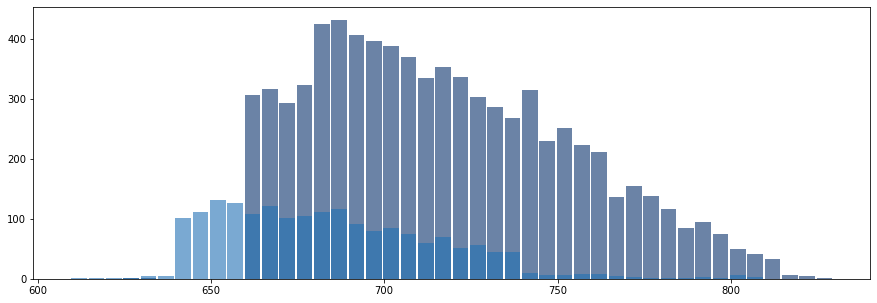

In [217]:
#credit worthyness fico difference
histc = thinkstats2.Hist(dfc["fico"])
histnc= thinkstats2.Hist(dfnc["fico"])
thinkplot.Hist(histc)
thinkplot.Hist(histnc)

In [218]:
dfcf=dfc["fico"]
dfncf=dfnc["fico"]

<AxesSubplot:xlabel='fico', ylabel='Density'>

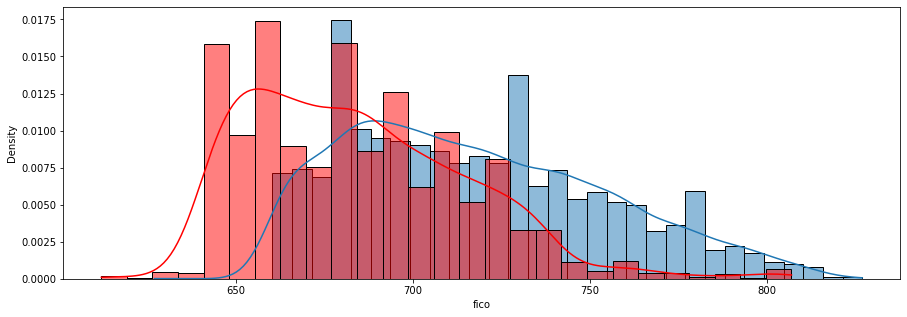

In [219]:
sns.histplot(dfcf, kde=True, stat="density")
sns.histplot(dfncf, kde=True, stat="density", color='red')

In [220]:
dfc.head(1)

,credit.policy,purpose,int.rate,installment,log.annual.inc,dti,fico,days.with.cr.line,revol.bal,revol.util,inq.last.6mths,not.fully.paid,grade
0,1,debt_consolidation,0.1189,829.1,11.350407,19.48,737,5639.958333,28854,52.1,0,0,good


In [221]:
#credit policy and income
dfci=dfc["log.annual.inc"]

In [222]:
dfnci=dfnc["log.annual.inc"]

In [223]:
#credit policy- 1
skw = thinkstats2.PearsonMedianSkewness(dfci)
print("Mean income with credit policy 1:",dfci.mean())
print("Median income with credit policy 1:",dfci.median())
print("skew income with credit policy 1:",skw)



Mean income with credit policy 1: 10.942680001295294
Median income with credit policy 1: 10.93310697
skew income with credit policy 1: 0.04906456323868525


In [224]:
# credit policy -0
skw = thinkstats2.PearsonMedianSkewness(dfnci)
print("Mean income with credit policy 0:",dfnci.mean())
print("Median income with credit policy 0:",dfnci.median())
print("skew income with credit policy 0:",skw)

Mean income with credit policy 0: 10.888519880012797
Median income with credit policy 0: 10.89673933
skew income with credit policy 0: -0.03414706719466611


In [225]:
dfci.count()

7710

In [226]:
#Get Statistics
mMean, fMean, mCount, fCount = dfci.mean(), dfnci.mean(), dfci.count(), dfnci.count()
mMean, fMean, mCount, fCount

(10.942680001295294, 10.888519880012797, 7710, 1868)

In [227]:
#Scipy ttest:
stat, pval = ss.ttest_ind(dfci, dfnci)
pval

0.0006337324172012597

In [228]:
#Statsmodels calculation of power. 
from statsmodels.stats.power import TTestPower
powerTest = TTestPower()
ces = thinkstats2.CohenEffectSize(dfci, dfnci)

alpha = .05
nobs = mCount + fCount

pow = powerTest.power(effect_size=ces, nobs=nobs, alpha=alpha)
pow, ces

(1.0, 0.08813984185782714)

In [229]:
# sample size
n = powerTest.solve_power(ces, power=.85, nobs=None, alpha=alpha)
n

1157.6455504969408

In [230]:
df_sam=df.sample(1158)

In [231]:
df_sam.describe()

,credit.policy,int.rate,installment,log.annual.inc,dti,fico,days.with.cr.line,revol.bal,revol.util,inq.last.6mths,not.fully.paid
count,1158.000000,1158.000000,1158.000000,1158.000000,1158.000000,1158.000000,1158.000000,1158.000000,1158.000000,1158.000000,1158.000000
mean,0.815199,0.124216,322.830155,10.936894,12.582202,708.554404,4503.912349,15817.740933,48.799162,1.626079,0.155440
std,0.388304,0.026714,207.590535,0.607970,6.774547,36.792911,2469.453980,25452.844187,28.953013,2.475654,0.362481
min,0.000000,0.060000,15.670000,8.101678,0.000000,627.000000,212.041667,0.000000,0.000000,0.000000,0.000000
25%,1.000000,0.107100,164.632500,10.561639,7.362500,682.000000,2769.520833,3324.500000,24.325000,0.000000,0.000000
50%,1.000000,0.125300,275.105000,10.933107,12.620000,702.000000,4097.020834,9114.500000,49.400000,1.000000,0.000000
75%,1.000000,0.142200,443.067500,11.286637,17.945000,732.000000,5669.958333,18000.250000,72.575000,2.000000,0.000000
max,1.000000,0.212100,913.630000,13.567049,29.700000,827.000000,14671.000000,338935.000000,105.200000,33.000000,1.000000


In [232]:
#Q-10- skew 
skw1=thinkstats2.PearsonMedianSkewness(df["fico"])
skw2=thinkstats2.PearsonMedianSkewness(df["days.with.cr.line"])
skw3=thinkstats2.PearsonMedianSkewness(df["log.annual.inc"])
print("Skew for Fico:",skw1)
print("Skew for Days with credit line:",skw2)
print("Skew for Income:",skw3)

Skew for Fico: 0.30390788935426843
Skew for Days with credit line: 0.5056178217400077
Skew for Income: 0.01892942352196182


In [246]:
df.head(2)

,credit.policy,purpose,int.rate,installment,log.annual.inc,dti,fico,days.with.cr.line,revol.bal,revol.util,inq.last.6mths,not.fully.paid,grade
0,1,debt_consolidation,0.1189,829.10,11.350407,19.48,737,5639.958333,28854,52.1,0,0,good
1,1,credit_card,0.1071,228.22,11.082143,14.29,707,2760.000000,33623,76.7,0,0,good


In [254]:
dfg=df[df["grade"]=='poor']
dfg.head()

,credit.policy,purpose,int.rate,installment,log.annual.inc,dti,fico,days.with.cr.line,revol.bal,revol.util,inq.last.6mths,not.fully.paid,grade


In [255]:
dfp=df[df["fico"]<580]
dfp

,credit.policy,purpose,int.rate,installment,log.annual.inc,dti,fico,days.with.cr.line,revol.bal,revol.util,inq.last.6mths,not.fully.paid,grade


In [234]:
# Q-12 there is no data for poor fico score 

In [256]:
#Q-13 - Brrowers
df.head(5)

,credit.policy,purpose,int.rate,installment,log.annual.inc,dti,fico,days.with.cr.line,revol.bal,revol.util,inq.last.6mths,not.fully.paid,grade
0,1,debt_consolidation,0.1189,829.10,11.350407,19.48,737,5639.958333,28854,52.1,0,0,good
1,1,credit_card,0.1071,228.22,11.082143,14.29,707,2760.000000,33623,76.7,0,0,good
2,1,debt_consolidation,0.1357,366.86,10.373491,11.63,682,4710.000000,3511,25.6,1,0,good
3,1,debt_consolidation,0.1008,162.34,11.350407,8.10,712,2699.958333,33667,73.2,1,0,good
4,1,credit_card,0.1426,102.92,11.299732,14.97,667,4066.000000,4740,39.5,0,0,fair
